
## 🧠 **Práctica 9: Interpretabilidad con SHAP**

SHAP (SHapley Additive exPlanations) es una técnica basada en teoría de juegos que asigna una contribución a cada característica para una predicción individual. Permite:

- Entender la importancia global de las variables.
- Visualizar el impacto de cada variable según su valor.
- Explicar predicciones específicas.

En este ejercicio, entrenamos un modelo y analizamos su interpretabilidad usando SHAP.


El objetivo principal es predecir la columna Churn en función de las demás variables. Esto se hace para:

✅ Identificar patrones que indiquen qué tipo de clientes son más propensos a abandonar el servicio.

✅ Detectar factores clave que influyen en la baja de clientes.

✅ Aplicar técnicas como SHAP para entender qué variables tienen mayor impacto en la decisión del cliente.

In [3]:
!pip install shap -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap

## 📋 **Descripción de las columnas**

customerID: Identificador único del cliente. ➔ ❌ No aporta valor predictivo, se suele eliminar del análisis.

tenure: Tiempo en meses que el cliente ha permanecido con el servicio. ➔ ✅ Probablemente sea una variable importante, ya que clientes con menos tiempo pueden tener mayor probabilidad de darse de baja.

PhoneService: Indica si el cliente tiene servicio telefónico (Yes o No). ➔ 🟠 Puede ser relevante si los clientes sin este servicio tienden a abandonar más.

Contract: Tipo de contrato del cliente (Month-to-month, One year, Two year). ➔ ✅ Suele ser un factor clave, ya que contratos mensuales tienden a tener mayor rotación.

PaperlessBilling: Indica si el cliente usa facturación electrónica. ➔ 🟠 Puede influir en la retención del cliente dependiendo de sus hábitos de pago.

PaymentMethod: Método de pago (Electronic check, Mailed check, Bank transfer, Credit card). ➔ ✅ Algunos métodos de pago podrían estar asociados con mayor probabilidad de baja.

MonthlyCharges: Monto que el cliente paga cada mes. ➔ ✅ Cuotas más altas podrían influir en la decisión de darse de baja.

TotalCharges: Total acumulado pagado por el cliente. ➔ ❗ Aunque parece una variable numérica, es de tipo object, lo que sugiere que tiene valores problemáticos (como espacios vacíos o datos no numéricos). Deberías convertirla a float tras manejar estos errores.

Churn: Variable objetivo que indica si el cliente se dio de baja (Yes o No). ➔ 🔥 Es la variable que intentaremos predecir.

In [6]:
# Cargar del dataset y la exploración
churn = pd.read_csv("C:Práctica 9. RECURSOS/churn_data.csv")
print(churn)
print(churn.info())
print(churn.duplicated().sum()) #duplicados

      customerID  tenure PhoneService        Contract PaperlessBilling  \
0     7590-VHVEG       1           No  Month-to-month              Yes   
1     5575-GNVDE      34          Yes        One year               No   
2     3668-QPYBK       2          Yes  Month-to-month              Yes   
3     7795-CFOCW      45           No        One year               No   
4     9237-HQITU       2          Yes  Month-to-month              Yes   
...          ...     ...          ...             ...              ...   
7038  6840-RESVB      24          Yes        One year              Yes   
7039  2234-XADUH      72          Yes        One year              Yes   
7040  4801-JZAZL      11           No  Month-to-month              Yes   
7041  8361-LTMKD       4          Yes  Month-to-month              Yes   
7042  3186-AJIEK      66          Yes        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Electronic check           

In [7]:
# análisis estadístico con media, mediana, minimo, maximo. 
# rango intercuartílico para valores atípicos y distribución de los datos 
print(churn.describe().T)

                 count       mean        std    min   25%    50%    75%  \
tenure          7043.0  32.371149  24.559481   0.00   9.0  29.00  55.00   
MonthlyCharges  7043.0  64.761692  30.090047  18.25  35.5  70.35  89.85   

                   max  
tenure           72.00  
MonthlyCharges  118.75  


## **Transformar columnas tipo Object**

📌 1. Variables categóricas con pocas categorías → One-Hot Encoding
Este método crea una columna para cada categoría, usando 0 y 1 para indicar su presencia.

📌 2. Variables categóricas con solo 2 valores → Label Encoding
Cuando una columna solo tiene dos opciones (Yes/No, Male/Female, etc.), puedes usar directamente 0 y 1.

✅ Ejemplo con la columna Churn:

Antes: Yes / No

Después: 1 / 0

📌 3. Columna TotalCharges (que parece numérica pero es object)
Esta columna puede tener valores vacíos o mal formateados. Para convertirla:


In [9]:
# vamos a hacer cambios
# eliminamos la columna customerID porque para el modelo no aporta valor predictivo
churn.drop(['customerID'], axis=1, inplace=True)

# Variables categóricas con pocas categorías usamos One-Hot Encoding
# drop_first=True elimina una de las categorias para evitar la trampa de la variable ficticia (dummy variable trap)
churn = pd.get_dummies(churn, columns=['Contract', 'PaymentMethod', 'PhoneService', 'PaperlessBilling'], drop_first=True)

# columnas categorias con solo dos valores usamos Label Encoding
# opciones de yes / no, las convertimos en 1 / 0.
churn['Churn'] = churn['Churn'].map({'Yes':1, 'No':0}) 

# TotalCharges que parece numerica pero es de tipo object
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce')

print(churn)
print(churn.info())
print(churn.describe().T)
print(churn.describe())

      tenure  MonthlyCharges  TotalCharges  Churn  Contract_One year  \
0          1           29.85         29.85      0              False   
1         34           56.95       1889.50      0               True   
2          2           53.85        108.15      1              False   
3         45           42.30       1840.75      0               True   
4          2           70.70        151.65      1              False   
...      ...             ...           ...    ...                ...   
7038      24           84.80       1990.50      0               True   
7039      72          103.20       7362.90      0               True   
7040      11           29.60        346.45      0              False   
7041       4           74.40        306.60      1              False   
7042      66          105.65       6844.50      0              False   

      Contract_Two year  PaymentMethod_Credit card (automatic)  \
0                 False                                  False   
1  

✅ One-Hot Encoding → Contract, PaymentMethod, PhoneService, PaperlessBilling

✅ Label Encoding → Churn

✅ Conversión numérica → TotalCharges

In [11]:
print(churn.duplicated().sum()) #duplicados

79


Ahora que ya estan limpios nuestros datos vamos a visualizarlos antes de entrenar a nuestro modelo

In [13]:
# vamos a ver que variables estan correlacionadas con la columna objetivo 
churn.corr()['Churn'].sort_values(ascending=False)

Churn                                    1.000000
PaymentMethod_Electronic check           0.301919
MonthlyCharges                           0.193356
PaperlessBilling_Yes                     0.191825
PhoneService_Yes                         0.011942
PaymentMethod_Mailed check              -0.091683
PaymentMethod_Credit card (automatic)   -0.134302
Contract_One year                       -0.177820
TotalCharges                            -0.199484
Contract_Two year                       -0.302253
tenure                                  -0.352229
Name: Churn, dtype: float64

In [14]:
# ahora vamos a obtener las características con mayor varianza, que suelen tener informacion valiosa
churn.var().sort_values(ascending=False)

TotalCharges                             5.138252e+06
MonthlyCharges                           9.054109e+02
tenure                                   6.031681e+02
PaperlessBilling_Yes                     2.415299e-01
PaymentMethod_Electronic check           2.230682e-01
Churn                                    1.949764e-01
Contract_Two year                        1.827710e-01
PaymentMethod_Mailed check               1.765189e-01
PaymentMethod_Credit card (automatic)    1.694255e-01
Contract_One year                        1.654262e-01
PhoneService_Yes                         8.746938e-02
dtype: float64

Dividimos el dataset en conjunto de entrenamiento y prueba

In [16]:
X = churn.drop('Churn', axis=1)
y = churn['Churn']

# división inicial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Validación Cruzada con K-Fold (k=5 y k=10)**

In [18]:
# Modelo de arbol de decisión
tree_model = DecisionTreeClassifier(random_state=42)

# Validación cruzada con k=5
scores_5 = cross_val_score(tree_model, X_train, y_train, cv=5, scoring='accuracy')

# Validación cruzada con  k=10
scores_10 = cross_val_score(tree_model, X_train, y_train, cv=10, scoring='accuracy')

print(f"Precisión Árbol (k=5): {scores_5.mean():.4f}")
print(f"Precisión Árbol (k=10): {scores_10.mean():.4f}")

Precisión Árbol (k=5): 0.7343
Precisión Árbol (k=10): 0.7242


## **Evaluación**


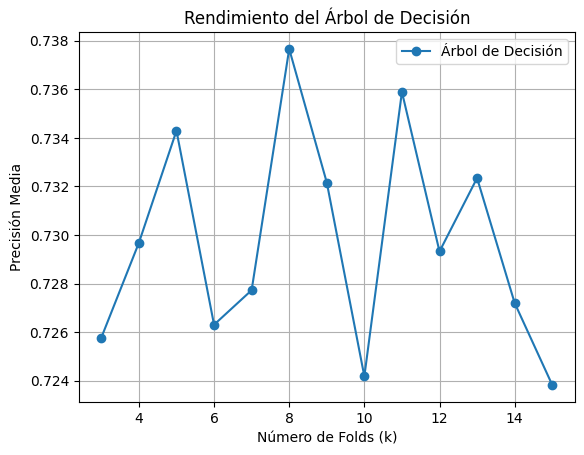

In [20]:
#Arbol de decision
k_values = range(3, 16)  # Valores de k de 3 a 15
tree_scores = [cross_val_score(tree_model, X_train, y_train, cv=k, scoring='accuracy').mean() for k in k_values]

plt.plot(k_values, tree_scores, marker='o', label='Árbol de Decisión')
plt.xlabel('Número de Folds (k)')
plt.ylabel('Precisión Media')
plt.title('Rendimiento del Árbol de Decisión')
plt.grid(True)
plt.legend()
plt.show()

# **SHAP**

In [22]:
# la libreria ya está importada
# calcular los valores SHAP
# crear el grafico resumen
# elegir las caracteristicas mas relevantes y generar un grafico de dependencia
# seleccionar una instancia especifica para el grafico de fuerza

In [23]:
# entrenar el modelo antes de usar SHAP
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
# Arbol de Decisión
# explicar las prediccioes del modelo usando SHAP
explainer = shap.TreeExplainer(tree_model)
shap_values = explainer(X_test)

print(type(shap_values))
print(shap_values.shape)

<class 'shap._explanation.Explanation'>
(1409, 10, 2)


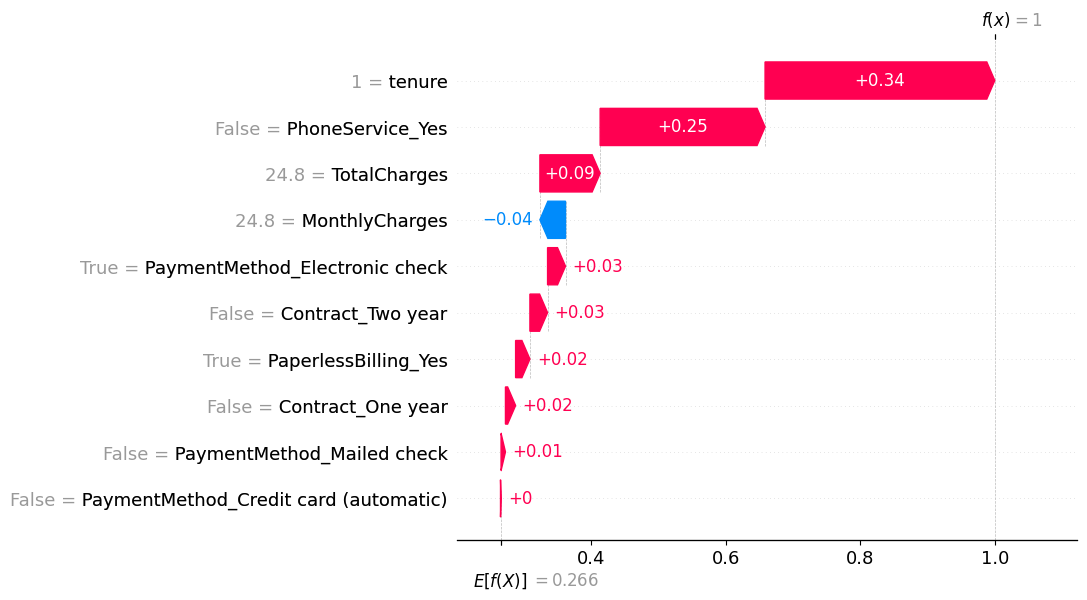

In [25]:
# Explicación de una predicción individual (clase 1)
shap.plots.waterfall(shap_values[0, :, 1])

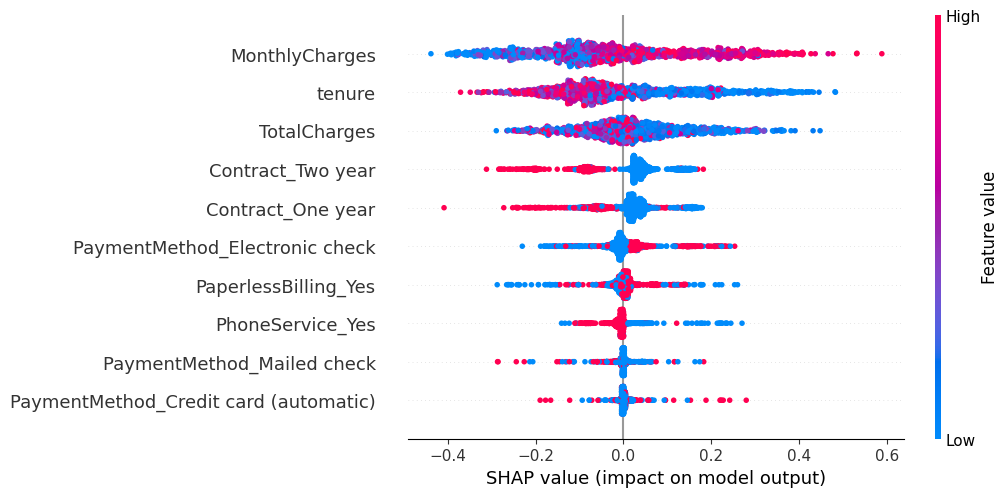

In [26]:
# Para obtener una visión general de qué características son las más importantes para un modelo, 
# podemos trazar los valores SHAP de cada característica para cada muestra
shap.plots.beeswarm(shap_values[..., 1])

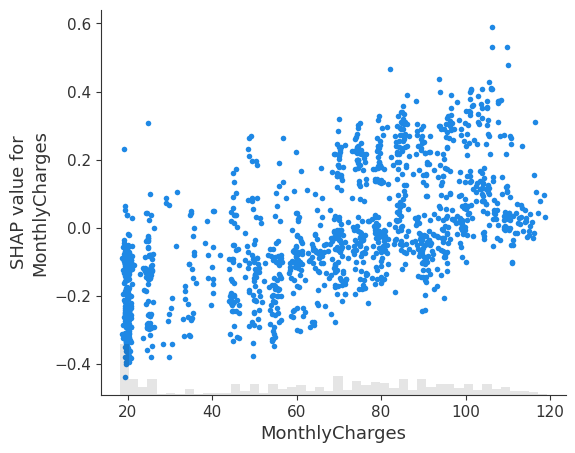

In [27]:
# Encontramos el índice de la columna 'MonthlyCharges'
monthly_charges_index = X_test.columns.get_loc("MonthlyCharges")

# Extraemos los valores SHAP para la característica 'MonthlyCharges' (una sola columna)
shap_values_monthly_charges = shap_values[:, monthly_charges_index, 1]

# Trazamos el valor SHAP de la característica 'MonthlyCharges' frente al valor de 'MonthlyCharges'
shap.plots.scatter(shap_values_monthly_charges)


## 📌 Conclusiones

🔍 **Características con mayor impacto en las predicciones:**
- Variables como `MonthlyCharges`, `tenure`, y `TotalCharges` tienen alto impacto.
- Clientes con menos `tenure` (tiempo de permanencia) tienden más a darse de baja.
- `MonthlyCharges` altos también están asociados a mayor probabilidad de cancelación.

⚖️ **¿Cómo ayuda SHAP a detectar sesgos o errores?:**
- Permite identificar si el modelo depende demasiado de ciertas variables.
- Visualiza de forma clara si hay variables irrelevantes o altamente correlacionadas influyendo en el modelo.

🚀 **Ventajas de SHAP frente a otros métodos:**
- Proporciona interpretabilidad **global** y **local**.
- Es compatible con múltiples tipos de modelos.
- Tiene visualizaciones intuitivas (beeswarm, waterfall, dependencia).

En resumen, SHAP es una herramienta potente para auditar y confiar más en nuestros modelos.
